In [1]:
import os
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from scipy.spatial.transform import Rotation


from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage


In [2]:
clist = np.array([[11, 60, 100], [162, 250, 163]])
clist2 = np.array([[50, 50, 50], [180, 180, 180]], dtype=np.uint8)

In [3]:
data_dir = '/scratch/shantanu/occant_evals/28022022/3x3/bt_discr/'

scenes = os.listdir(data_dir)

In [4]:
def convert_world2map(world_coors, map_shape, map_scale):
    """
    World coordinate system:
        Agent starts at (0, 0) facing upward along X. Y is rightward.
    Map coordinate system:
        Agent starts at (W/2, H/2) with X rightward and Y downward.

    Inputs:
        world_coors: (bs, 2) --- (x, y) in world coordinates
        map_shape: tuple with (H, W)
        map_scale: scalar indicating the cell size in the map
    """
    H, W = map_shape
    Hby2 = (H - 1) / 2 if H % 2 == 1 else H // 2
    Wby2 = (W - 1) / 2 if W % 2 == 1 else W // 2

    x_world = world_coors[:, 0]
    y_world = world_coors[:, 1]

    x_map = torch.clamp((Wby2 + y_world / map_scale), 0, W - 1).round()
    y_map = torch.clamp((Hby2 - x_world / map_scale), 0, H - 1).round()

    map_coors = torch.stack([x_map, y_map], dim=1)  # (bs, 2)

    return map_coors

In [5]:
def to_map_coord(sim, world_point, grid_dimensions):
    return maps.to_grid(
            world_point[2],
            world_point[0],
            grid_dimensions,    
            pathfinder=sim.pathfinder,
        )

def to_world_coord(sim, map_point, grid_dimensions):
    new_pos_x, new_pos_y = maps.from_grid(
                    map_point[0],
                    map_point[1],
                    grid_dimensions,
                    pathfinder=sim.pathfinder,
                )

    return [new_pos_y, 0, new_pos_x]

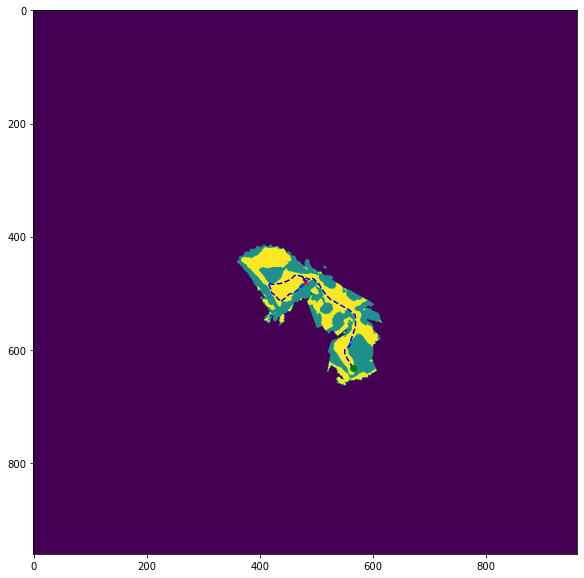

In [6]:
pose_dir = '/scratch/shantanu/occant_evals/28022022/3x3/bt_discr/Cantwell/0/pose/'
filenames = sorted(os.listdir(pose_dir), key=lambda x: int(x.split('.')[0]))

poses = []
for filename in filenames:
    pose = np.load(os.path.join(pose_dir, filename))
    pose = torch.from_numpy(pose).unsqueeze(dim=0)
    world_pose = convert_world2map(pose[:, :2], (961, 961), 0.05)
    poses.append(world_pose)
    
poses = torch.vstack(poses).numpy()

global_map_fp = os.path.join('/scratch/shantanu/occant_evals/28022022/3x3/bt_discr/Cantwell/0/global_map/', 
                             filenames[-1].replace('.npy','.png'))
global_map = cv2.imread(global_map_fp, -1)

fig = plt.figure(figsize=(10, 10))

plt.imshow(global_map)
plt.plot(poses[:, 0], poses[:, 1], '--b')
plt.plot(poses[0, 0], poses[0, 1], 'rx')
plt.plot(poses[-1, 0], poses[-1, 1], 'go')

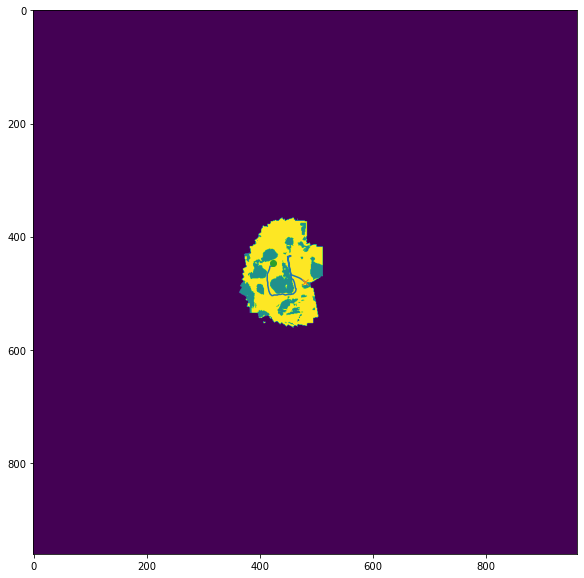

In [7]:
pose_dir = '/scratch/shantanu/occant_evals/28022022/3x3/occant_rgb/Cantwell/21/pose/'
filenames = sorted(os.listdir(pose_dir), key=lambda x: int(x.split('.')[0]))

poses = []
for filename in filenames:
    pose = np.load(os.path.join(pose_dir, filename))
    pose = torch.from_numpy(pose).unsqueeze(dim=0)
    world_pose = convert_world2map(pose[:, :2], (961, 961), 0.05)
    poses.append(world_pose)
    
poses = torch.vstack(poses).numpy()

global_map_fp = os.path.join('/scratch/shantanu/occant_evals/28022022/3x3/occant_rgb/Cantwell/21/global_map/', 
                             filenames[-1].replace('.npy','.png'))
global_map = cv2.imread(global_map_fp, -1)

fig = plt.figure(figsize=(10, 10))

plt.imshow(global_map)
plt.plot(poses[:, 0], poses[:, 1])
plt.plot(poses[0, 0], poses[0, 1], 'x')
plt.plot(poses[-1, 0], poses[-1, 1], 'o')

In [8]:
ep_dir = os.listdir('/scratch/shantanu/occant_evals/28022022/3x3/occant_rgb/Cantwell/')
ep_dir = sorted(ep_dir, key=lambda x: int(x))

ep_lens = {
    'occant_rgb': None,
    'bt_discr': None
}

for model in ep_lens.keys():
    data_dir = f'/scratch/shantanu/occant_evals/28022022/3x3/{model}/Cantwell/'
    ep_lens[model] = np.array([len(os.listdir(os.path.join(data_dir, x, 'pose'))) for x in ep_dir])

In [9]:
idx = np.argmin(ep_lens['bt_discr'] - ep_lens['occant_rgb'])
idx, ep_lens['occant_rgb'][idx], ep_lens['bt_discr'][idx]

(69, 500, 79)

In [10]:
val_idx = [idx for idx in range(len(ep_dir)) if ep_lens['occant_rgb'][idx] < 200]
print(len(val_idx))

idx = np.argmin(ep_lens['bt_discr'][val_idx] - ep_lens['occant_rgb'][val_idx])
val_idx[idx], ep_lens['occant_rgb'][val_idx][idx], ep_lens['bt_discr'][val_idx][idx]

21


(63, 133, 65)

In [11]:
import json

In [12]:
val_split = json.load(open('/scratch/shaantanu/OccupancyAnticipation/data/datasets/pointnav/gibson/v1/val/val.json', 'r'))

In [13]:
[x for x in val_split['episodes'] if x['episode_id'] == 21 and x['scene_id'] == 'data/scene_datasets/gibson/Cantwell.glb']

[{'episode_id': 21,
  'scene_id': 'data/scene_datasets/gibson/Cantwell.glb',
  'start_position': [-3.85515, 0.15825, -2.98223],
  'start_rotation': [0, 0.09338, 0, -0.99563],
  'info': {'geodesic_distance': 6.68912},
  'goals': [{'position': [-6.16232, 0.15825, -5.20815], 'radius': None}],
  'shortest_paths': None,
  'start_room': None}]

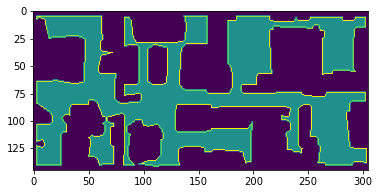

In [14]:
global_map = cv2.imread('/scratch/shantanu/top_down_cantwell.png', -1)
plt.imshow(global_map)

In [15]:
Rotation.from_quat([0, 0.09338, 0, -0.99563]).as_euler('XYZ')

array([ 0.        , -0.18703259,  0.        ])

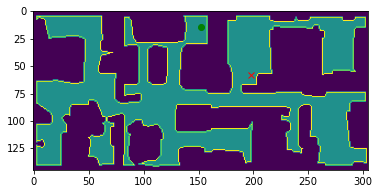

In [16]:
plt.imshow(global_map)
plt.plot([198], [58], 'rx')
plt.plot([152], [14], 'go')

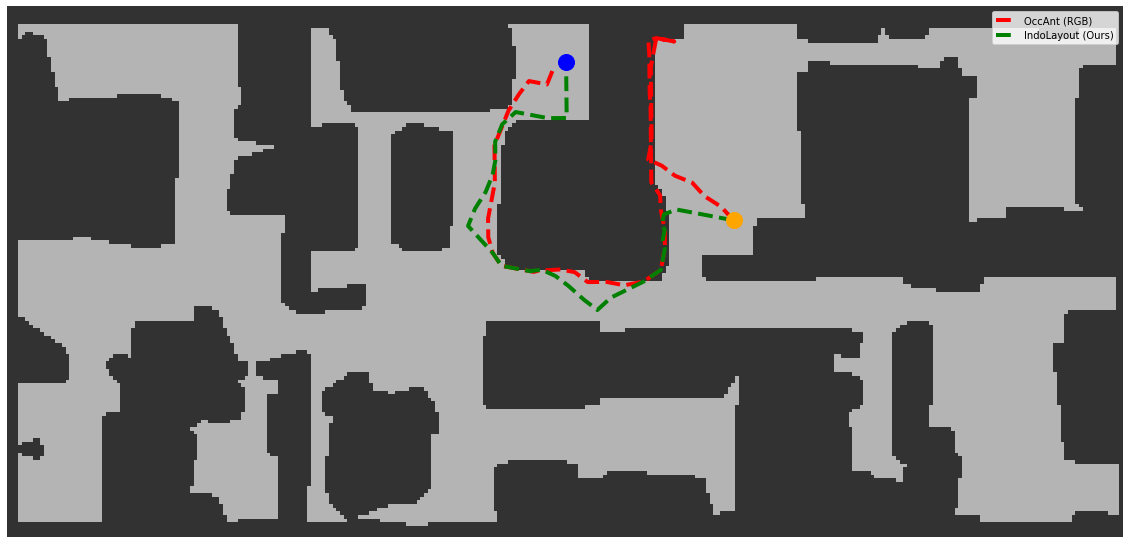

In [17]:
theta = 0.18703259 - np.pi/2
px = 198
py = 58

T = np.eye(3)
T[0, 0] = np.cos(theta)
T[0, 1] = -np.sin(theta)
T[1, 0] = np.sin(theta)
T[1, 1] = np.cos(theta)
T[0, 2] = px
T[1, 2] = py

pose_dir = '/scratch/shantanu/occant_evals/28022022/3x3/occant_rgb/Cantwell/21/pose/'
filenames = sorted(os.listdir(pose_dir), key=lambda x: int(x.split('.')[0]))

poses = []
for filename in filenames:
    pose = np.load(os.path.join(pose_dir, filename))
    pose = torch.from_numpy(pose).unsqueeze(dim=0)
    poses.append(pose[:, :2])
    
poses = torch.vstack(poses).numpy()//0.05

poses_global = T @ np.concatenate([poses, np.ones((poses.shape[0], 1))], axis=-1).T
poses_global = poses_global[:2, :].T

fig = plt.figure(figsize=(20,20))
ax = plt.gca()

global_map = cv2.imread('/scratch/shantanu/top_down_cantwell.png', -1)//127
global_map[global_map==2] = 1
global_map = clist2[global_map.reshape(-1)].reshape((*global_map.shape, 3))

plt.imshow(global_map, interpolation='None')
plt.plot(poses_global[:, 0], poses_global[:, 1], '--r', linewidth=4, label='OccAnt (RGB)')

# cols = np.linspace(0,1,poses_global.shape[0])
# points = poses_global.reshape(-1, 1, 2)
# segments = np.concatenate([points[:-1], points[1:]], axis=1)

# lc = LineCollection(segments, cmap='viridis')
# lc.set_array(cols)
# lc.set_linewidth(6)
# line = ax.add_collection(lc)
# fig.colorbar(line,ax=ax, fraction=0.046, pad=0.04)


# bt_discr
pose_dir = '/scratch/shantanu/occant_evals/28022022/3x3/bt_discr/Cantwell/21/pose/'
filenames = sorted(os.listdir(pose_dir), key=lambda x: int(x.split('.')[0]))

poses = []
for filename in filenames:
    pose = np.load(os.path.join(pose_dir, filename))
    pose = torch.from_numpy(pose).unsqueeze(dim=0)
    poses.append(pose[:, :2])
    
poses = torch.vstack(poses).numpy()//0.05

poses_global = T @ np.concatenate([poses, np.ones((poses.shape[0], 1))], axis=-1).T
poses_global = poses_global[:2, :].T
plt.plot(poses_global[:, 0], poses_global[:, 1], '--g', linewidth=4, label='IndoLayout (Ours)')
plt.plot(poses_global[0, 0], poses_global[0, 1], 'o', markersize=16, color='orange')
plt.plot(poses_global[-1, 0], poses_global[-1, 1], 'o', markersize=16, color='blue')

# cols = np.linspace(0,1,poses_global.shape[0])
# points = poses_global.reshape(-1, 1, 2)
# segments = np.concatenate([points[:-1], points[1:]], axis=1)

# lc = LineCollection(segments, cmap='plasma')
# lc.set_array(cols)
# lc.set_linewidth(6)
# line = ax.add_collection(lc)
# fig.colorbar(line,ax=ax, fraction=0.046, pad=0.04)

ax.axis('off')

plt.legend()
# plt.tight_layout()
plt.show()

In [180]:
global_map.shape

(145, 305, 3)

In [208]:
145//2

72

In [189]:
np.array(global_map.shape[:2])

array([145, 305])

In [196]:
np.array([-3.85515, -2.98223])//0.05

array([-78., -60.])

In [199]:
198 + 78, 60+58

(276, 118)

In [18]:
def get_plot(traj_id, pos):
       
    ep_data = [x for x in val_split['episodes'] if x['episode_id'] == traj_id 
               and x['scene_id'] == 'data/scene_datasets/gibson/Cantwell.glb'][0]
    
    agent_pos = np.array(ep_data['start_position']) // 0.05
    agent_rot = Rotation.from_quat(ep_data['start_rotation']).as_rotvec()[1]
    
    theta = -agent_rot #+ np.pi/2
    py, px = pos
    
    print(traj_id, np.rad2deg(Rotation.from_quat(ep_data['start_rotation']).as_rotvec()[1]))

    T = np.eye(3)
    T[0, 0] = np.cos(theta)
    T[0, 1] = -np.sin(theta)
    T[1, 0] = np.sin(theta)
    T[1, 1] = np.cos(theta)
    T[0, 2] = px
    T[1, 2] = py
    
    rot_Y_90 = np.zeros((3, 3))
    rot_Y_90[0, 1] = 1
    rot_Y_90[1, 0] = -1
    rot_Y_90[2, 2] = 1
    
    T = T @ rot_Y_90

    pose_dir = f'/scratch/shantanu/occant_evals/28022022/3x3/occant_rgb/Cantwell/{traj_id}/pose/'
    filenames = sorted(os.listdir(pose_dir), key=lambda x: int(x.split('.')[0]))

    poses = []
    for filename in filenames:
        pose = np.load(os.path.join(pose_dir, filename))
        pose = torch.from_numpy(pose).unsqueeze(dim=0)
        poses.append(pose[:, :2])

    poses = torch.vstack(poses).numpy()//0.05

    poses_global = T @ np.concatenate([poses, np.ones((poses.shape[0], 1))], axis=-1).T
    poses_global = poses_global[:2, :].T

    fig = plt.figure(figsize=(20,20))
    ax = plt.gca()

    global_map = cv2.imread('/scratch/shantanu/top_down_cantwell.png', -1)//127
    global_map[global_map==2] = 1
    global_map = clist2[global_map.reshape(-1)].reshape((*global_map.shape, 3))

    plt.imshow(global_map, interpolation='None')
    plt.plot(poses_global[:, 0], poses_global[:, 1], '--r', linewidth=4, label='OccAnt (RGB)')

    # cols = np.linspace(0,1,poses_global.shape[0])
    # points = poses_global.reshape(-1, 1, 2)
    # segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # lc = LineCollection(segments, cmap='viridis')
    # lc.set_array(cols)
    # lc.set_linewidth(6)
    # line = ax.add_collection(lc)
    # fig.colorbar(line,ax=ax, fraction=0.046, pad=0.04)


    # bt_discr
    pose_dir = f'/scratch/shantanu/occant_evals/28022022/3x3/bt_discr/Cantwell/{traj_id}/pose/'
    filenames = sorted(os.listdir(pose_dir), key=lambda x: int(x.split('.')[0]))

    poses = []
    for filename in filenames:
        pose = np.load(os.path.join(pose_dir, filename))
        pose = torch.from_numpy(pose).unsqueeze(dim=0)
        poses.append(pose[:, :2])

    poses = torch.vstack(poses).numpy()//0.05

    poses_global = T @ np.concatenate([poses, np.ones((poses.shape[0], 1))], axis=-1).T
    poses_global = poses_global[:2, :].T
    plt.plot(poses_global[:, 0], poses_global[:, 1], '--g', linewidth=4, label='IndoLayout (Ours)')
    plt.plot(poses_global[0, 0], poses_global[0, 1], 'o', markersize=16, color='orange')
    plt.plot(poses_global[-1, 0], poses_global[-1, 1], 'o', markersize=16, color='blue')

    # cols = np.linspace(0,1,poses_global.shape[0])
    # points = poses_global.reshape(-1, 1, 2)
    # segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # lc = LineCollection(segments, cmap='plasma')
    # lc.set_array(cols)
    # lc.set_linewidth(6)
    # line = ax.add_collection(lc)
    # fig.colorbar(line,ax=ax, fraction=0.046, pad=0.04)

    ax.axis('off')

    plt.legend()
    # plt.tight_layout()
    
    img = mplfig_to_npimage(fig)
    plt.close(fig)
    
    return img

In [19]:
sp = [(x['episode_id'], np.array(x['start_position'])) for x in val_split['episodes'] if x['scene_id'] == 'data/scene_datasets/gibson/Cantwell.glb']
np.array([x[1] for x in sp]).tolist()[:5]

[[-4.69643, 0.15825, -2.90618],
 [-0.27251, 0.15825, -1.17589],
 [-3.92178, 0.15825, -0.08615],
 [-7.23818, 0.15825, -0.02986],
 [-7.53066, 0.15825, -3.34582]]

In [20]:
global_sp = [(60, 182), (94, 270), (116, 197), (117, 131), (51, 125), (124, 282), (17, 157), (79, 292), (86, 210), (12, 257), (128, 275), (61, 186), (78, 13), (107, 196), (49, 47), (28, 181), (74, 154), (81, 117), (95, 226), (17, 207), (43, 272), (58, 198), (73, 150), (86, 279), (23, 30), (87, 166), (16, 274), (81, 259), (93, 107), (133, 21), (86, 211), (28, 178), (74, 287), (6, 85), (31, 197), (24, 263), (110, 13), (113, 147), (139, 83), (11, 202), (23, 291), (128, 12), (19, 19), (68, 35), (95, 98), (138, 277), (83, 226), (133, 16), (116, 279), (37, 182), (61, 45), (16, 262), (31, 283), (76, 117), (97, 279), (14, 236), (31, 267), (43, 184), (129, 127), (15, 210), (109, 127), (16, 88), (40, 61), (110, 22), (112, 239), (127, 17), (134, 81), (46, 196), (24, 211), (95, 18), (12, 216)]
global_sp = np.array(global_sp)

print(global_sp.shape)

(71, 2)


26 -17.023171283839197


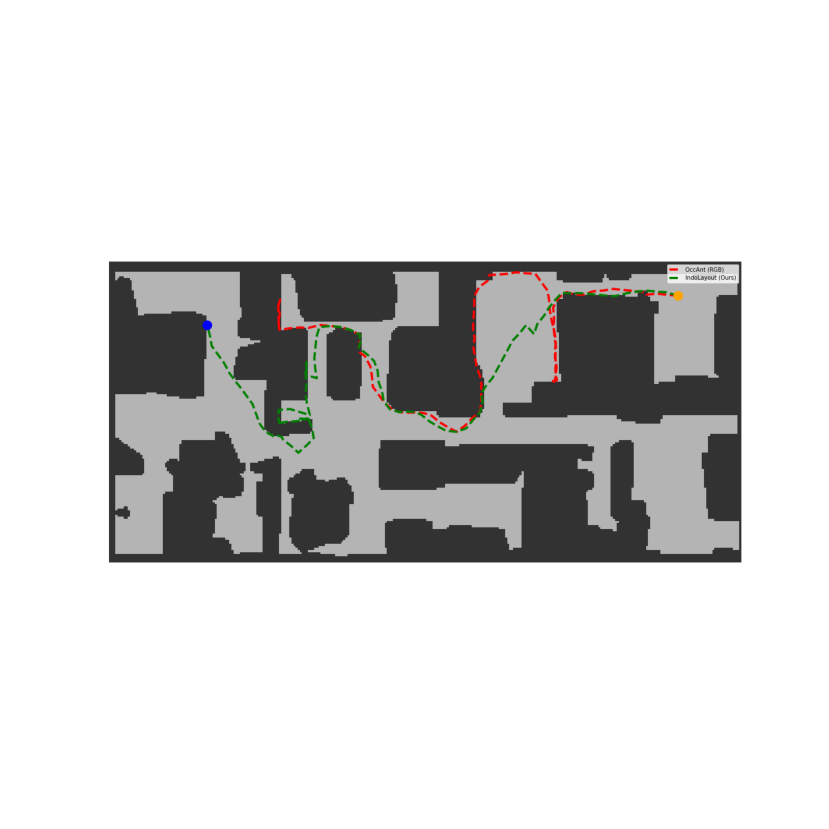

In [21]:
img = get_plot(26, global_sp[26])
fig = plt.figure(figsize=(15, 15))
plt.imshow(img)
plt.gca().axis('off')
plt.show()

In [316]:
out_dir = '/scratch/shantanu/iros_video/pointnav_traj2'
os.makedirs(out_dir, exist_ok=True)

for traj_id in ep_dir:
    traj_id = int(traj_id)
    img = get_plot(traj_id, global_sp[traj_id])
    
    out_path = os.path.join(out_dir, f'{traj_id}.png')
    print(cv2.imwrite(out_path, cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))

0 -133.64660439021506
True
1 -144.57020355953983
True
2 -175.01711120828435
True
3 -99.96117150719562
True
4 169.34140221844527
True
5 -1.2754279108637687
True
6 -106.64179700530252
True
7 -74.59144622091164
True
8 -100.4240703923724
True
9 -63.683900078731384
True
10 -86.48686806446531
True
11 -176.34046911663225
True
12 0.16844947043437838
True
13 -90.17583208146644
True
14 -60.44903111905034
True
15 129.03675380586733
True
16 148.94644149911605
True
17 -85.26255279934114
True
18 -121.57113476012483
True
19 -138.35303990675044
True
20 53.20389781770878
True
21 -10.716178085756662
True
22 -163.7897088802419
True
23 -141.98752599835015
True
24 127.90817698470346
True
25 -179.16461727200607
True
26 -17.023171283839197
True
27 -22.99674223472789
True
28 16.120025174701144
True
29 26.1163509680471
True
30 21.79576724351696
True
31 75.33679637396281
True
32 144.42849672388402
True
33 -82.94685312617523
True
34 -148.3511381831789
True
35 -165.95137122486994
True
36 106.85218653981464
True
3

In [22]:
def save_video(scene_id, traj_id, pose, save_path):    
    ep_data = [x for x in val_split['episodes'] if x['episode_id'] == traj_id 
               and x['scene_id'] == f'data/scene_datasets/gibson/{scene_id}.glb'][0]
    
    agent_pos = np.array(ep_data['start_position']) // 0.05
    agent_rot = Rotation.from_quat(ep_data['start_rotation']).as_euler('XYZ')[1]
    
    theta = -agent_rot
    py, px = pose

    T = np.eye(3)
    T[0, 0] = np.cos(theta)
    T[0, 1] = -np.sin(theta)
    T[1, 0] = np.sin(theta)
    T[1, 1] = np.cos(theta)
    T[0, 2] = px
    T[1, 2] = py
    
    rot_Y_90 = np.zeros((3, 3))
    rot_Y_90[0, 1] = 1
    rot_Y_90[1, 0] = -1
    rot_Y_90[2, 2] = 1
    
    T = T @ rot_Y_90    
    
    ## Load RGB Global Poses
    rgb_posedir = f'/scratch/shantanu/occant_evals/28022022/3x3/occant_rgb/{scene_id}/{traj_id}/pose/'
    filenames = sorted(os.listdir(rgb_posedir), key=lambda x: int(x.split('.')[0]))

    rgb_poses = []
    for filename in filenames:
        pose = np.load(os.path.join(rgb_posedir, filename))
        pose = torch.from_numpy(pose).unsqueeze(dim=0)
        rgb_poses.append(pose[:, :2])

    rgb_poses = torch.vstack(rgb_poses).numpy()//0.05

    rgbposes_global = T @ np.concatenate([rgb_poses, np.ones((rgb_poses.shape[0], 1))], axis=-1).T
    rgbposes_global = rgbposes_global[:2, :].T
    
    ## Load Indolayout Global Poses
    il_posedir = f'/scratch/shantanu/occant_evals/28022022/3x3/bt_discr/{scene_id}/{traj_id}/pose/'
    filenames = sorted(os.listdir(il_posedir), key=lambda x: int(x.split('.')[0]))

    il_poses = []
    for filename in filenames:
        pose = np.load(os.path.join(il_posedir, filename))
        pose = torch.from_numpy(pose).unsqueeze(dim=0)
        il_poses.append(pose[:, :2])

    il_poses = torch.vstack(il_poses).numpy()//0.05

    ilposes_global = T @ np.concatenate([il_poses, np.ones((il_poses.shape[0], 1))], axis=-1).T
    ilposes_global = ilposes_global[:2, :].T
    
    
    # Global map
    global_map = cv2.imread('/scratch/shantanu/top_down_cantwell.png', -1)//127
    global_map[global_map==2] = 1
    global_map = clist2[global_map.reshape(-1)].reshape((*global_map.shape, 3))

    
    # Setup video params
    num_frames = max(rgbposes_global.shape[0], ilposes_global.shape[0]) + 5
    fps = 60
    duration = num_frames // fps
    print(num_frames, duration)
    
    # Setup plot
    fig = plt.figure(figsize=(15, 15))
    ax = plt.gca()

    def get_frame(t):   
        ax.clear()
            
        idx = int(t * fps)
        
        ax.imshow(global_map, interpolation='None')
        
        ax.plot(rgbposes_global[:idx, 0], rgbposes_global[:idx, 1], '--r', linewidth=4, label='OccAnt (RGB)')
        ax.plot(ilposes_global[:idx, 0], ilposes_global[:idx, 1], '--g', linewidth=4, label='IndoLayout (Ours)')
        ax.plot(ilposes_global[0, 0], ilposes_global[0, 1], 'o', markersize=16, color='orange')
        ax.plot(ilposes_global[-1, 0], ilposes_global[-1, 1], 'o', markersize=16, color='blue')
        
        ax.axis('off')
        ax.legend()
        
        img = mplfig_to_npimage(fig)
        
        return img


    animation = VideoClip(get_frame, duration = duration)
    animation.write_videofile(save_path, fps=fps)

505 8
Moviepy - Building video /scratch/shantanu/iros_video/Cantwell_26_speed.mp4.
Moviepy - Writing video /scratch/shantanu/iros_video/Cantwell_26_speed.mp4



Moviepy - Done !
Moviepy - video ready /scratch/shantanu/iros_video/Cantwell_26_speed.mp4


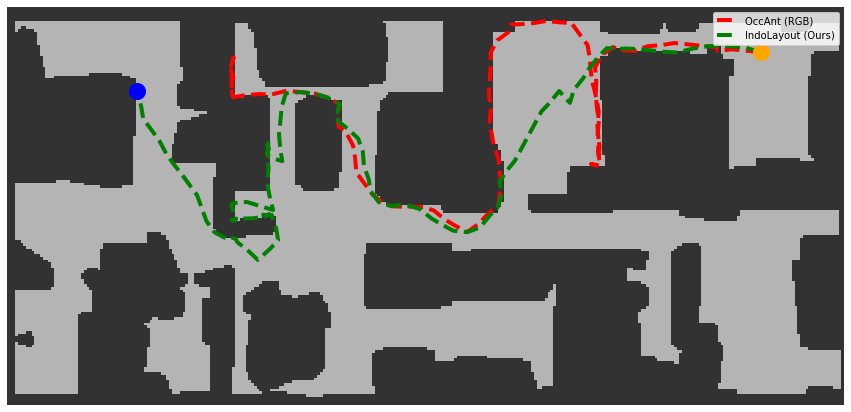

In [23]:
save_video("Cantwell", 26, global_sp[26], '/scratch/shantanu/iros_video/Cantwell_26_speed.mp4')

# Mapping Cantwell

In [6]:
data_dir = '/scratch/shantanu/iros_video/mapping2/Cantwell'

In [17]:
filenames = sorted([x for x in os.listdir(data_dir) if os.path.splitext(x)[1] == '.png'], 
                       key=lambda x: int(x.replace('Cantwell_', '').replace('.png', '')))

len(filenames)/61

4.0

In [21]:
246/3

82.0

In [22]:
def save_video(data_path, save_path):    
    filenames = sorted([x for x in os.listdir(data_path) if os.path.splitext(x)[1] == '.png'], 
                       key=lambda x: int(x.replace('Cantwell_', '').replace('.png', '')))
    
    filenames += [filenames[-1]] * 4  # To hold the last frame for a few seconds

    # Setup video params
    num_frames = len(filenames)
    fps = 82
    duration = num_frames // fps
    print(num_frames, duration)
    
    def get_frame(t):             
        idx = int(t * fps)
                    
        img_path = os.path.join(data_path, filenames[idx])
        img = cv2.cvtColor(cv2.imread(img_path, -1), cv2.COLOR_BGR2RGB).astype(float)
        
        return img


    animation = VideoClip(get_frame, duration = duration)
    animation.write_videofile(save_path, fps=fps)

In [12]:
# def save_video(data_path, save_path):    
#     filenames = sorted([x for x in os.listdir(data_path) if os.path.splitext(x)[1] == '.png'], 
#                        key=lambda x: int(x.replace('Cantwell_', '').replace('.png', '')))
    
#     filenames += [filenames[-1]] * 24  # To hold the last frame for a few seconds

#     # Setup video params
#     num_frames = len(filenames)
#     fps = 60
#     duration = num_frames // fps
#     print(num_frames, duration)
    
#     fadeout = len(filenames) // 2
#     fadein = 6 * len(filenames) // 10
    
#     def get_frame(t):   
            
#         idx = int(t * fps)
        
#         if idx < fadeout:     
#             img_path = os.path.join(data_path, filenames[idx])
#             img = cv2.cvtColor(cv2.imread(img_path, -1), cv2.COLOR_BGR2RGB).astype(float)

#             white = np.ones_like(img).astype(float) *  255
#             fac = (idx/fadeout) ** 2

#             merged_img = (img * (1 - fac) + white * fac).astype(np.uint8)
#         elif idx >= fadeout and idx < fadein:
#             img_path = os.path.join(data_path, filenames[idx])
#             img = cv2.cvtColor(cv2.imread(img_path, -1), cv2.COLOR_BGR2RGB).astype(float)
#             merged_img = np.ones_like(img).astype(float) *  255
#         else:
#             img_path = os.path.join(data_path, filenames[-1])
#             img = cv2.cvtColor(cv2.imread(img_path, -1), cv2.COLOR_BGR2RGB).astype(float)

#             white = np.ones_like(img).astype(float) *  255
#             fac = ((idx - fadein)/(num_frames - fadein - fps)) ** 2
#             fac = min(fac, 1)

#             merged_img = (img * fac + white * (1- fac)).astype(np.uint8)
        
#         return merged_img


#     animation = VideoClip(get_frame, duration = duration)
#     animation.write_videofile(save_path, fps=fps)

In [23]:
save_video(data_dir, '/home/shantanu.singh/mapping2.mp4')

t:   1%|█▊                                                                                                                                                                                                                                                                      | 2/300 [03:52<9:38:02, 116.38s/it, now=None]

248 3
Moviepy - Building video /home/shantanu.singh/mapping2.mp4.
Moviepy - Writing video /home/shantanu.singh/mapping2.mp4




t:   1%|█▊                                                                                                                                                                                                                                                                      | 2/300 [03:54<9:42:19, 117.25s/it, now=None]

Moviepy - Done !
Moviepy - video ready /home/shantanu.singh/mapping2.mp4
